In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
# import a file from drive : 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/open?id=1g2BefhpdVbg6aeFcngD52p_HLza6nQDm'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('IMDB Dataset.csv')  
imdb = pd.read_csv('IMDB Dataset.csv')


1g2BefhpdVbg6aeFcngD52p_HLza6nQDm


In [0]:
x = imdb["review"]
y = [1 if word=="positive" else 0 for word in imdb["sentiment"]]

In [0]:
stop_words = set(stopwords.words('english'))- set(['no', 'not', 'nor'])
lemmatizer = WordNetLemmatizer() 

def preprocess_text(text):
  # Removing html tags
  text = re.sub(r'<[^>]+>', '', text)
  
  # Remove punctuations and numbers
  text = re.sub('[^a-zA-Z]', ' ', text)

  # Remove subsequent spaces
  text = re.sub(r'\s+', ' ', text)
  
  return text.lower()

In [6]:
preprocess_text("I love this is this the best or the worst, my eyes are popping out <br hd='strng'>")

'i love this is this the best or the worst my eyes are popping out '

In [0]:
x = [preprocess_text(review) for review in imdb["review"]]

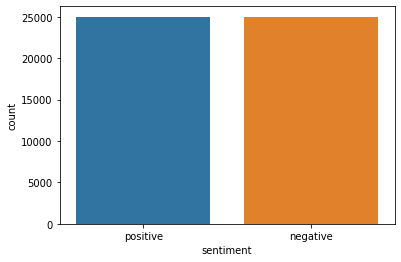

In [8]:
import seaborn as sns

sns.countplot(x='sentiment', data=imdb)

In [9]:
from keras.preprocessing import sequence 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 220

y = [1 if sentiment=='positive' else 0 for sentiment in list(imdb['sentiment'])]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
x = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_words, padding="post")


Using TensorFlow backend.


In [10]:
# Build the model
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras import optimizers


# Set the vocab size for all words
vocabulary_size = len(tokenizer.word_counts.keys())+1
# vocabulary_size = 25000

embedding_size=32
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(64, dropout=0.4))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer= 'RMSprop', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 220, 32)           3244768   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,269,665
Trainable params: 3,269,665
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [12]:
batchSize = 512
epochs = 5
hist = model.fit(xTrain, yTrain, batch_size=batchSize, epochs=epochs, verbose=1, shuffle=True, validation_split=0.2)






Train on 36000 samples, validate on 9000 samples
Epoch 1/5





36000/36000 [==============================] - 73s 2ms/step - loss: 0.6958 - acc: 0.5509 - val_loss: 0.7403 - val_acc: 0.6434
Epoch 2/5
36000/36000 [==============================] - 72s 2ms/step - loss: 0.5432 - acc: 0.7584 - val_loss: 0.4364 - val_acc: 0.8214
Epoch 3/5
36000/36000 [==============================] - 72s 2ms/step - loss: 0.4077 - acc: 0.8463 - val_loss: 0.3564 - val_acc: 0.8697
Epoch 4/5
36000/36000 [==============================] - 71s 2ms/step - loss: 0.3436 - acc: 0.8789 - val_loss: 0.3220 - val_acc: 0.8803
Epoch 5/5
36000/36000 [==============================] - 72s 2ms/step - loss: 0.2941 - acc: 0.8991 - val_loss: 0.3073 - val_acc: 0.8867


In [13]:
scores = model.evaluate(xTest, yTest, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8814


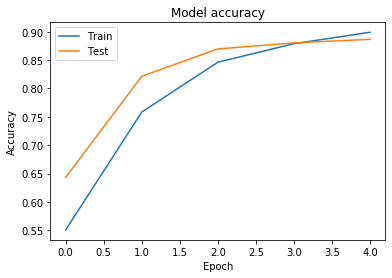

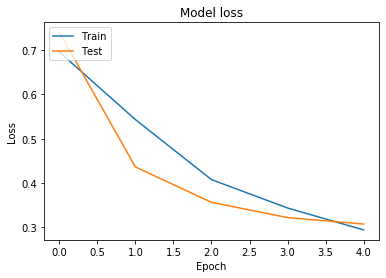

In [14]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show() 

In [15]:
instance = ["awesome i will definetly use it again"]
instance = tokenizer.texts_to_sequences(instance)

instance = pad_sequences(instance, maxlen=max_words, padding="post")
print(model.predict_classes(instance))
print(model.predict(instance))

[[1]]
[[0.943268]]


In [16]:
test_1 = "This movie is great, I simply love it"
test_2 = "Good movie!"
test_3 = "if you like action, then this movie is good for you"
test_4 = "Maybe I like this movie!"
test_5 = "Not my taste, will skip and watch another movie"
test_6 = "Bad Movie!"
test_7 = "Not a good service "
test_8 = "This movie really sucks! Can I get my money back please?"

test_samples = [test_1, test_2, test_3, test_4, test_5, test_6, test_7, test_8]

test_samples_tokens = tokenizer.texts_to_sequences(test_samples)



predicted_tokenized = pad_sequences(test_samples_tokens, maxlen=max_words, padding="post")
model.predict(predicted_tokenized)

array([[0.9432456 ],
       [0.04779992],
       [0.9366168 ],
       [0.04702398],
       [0.04700956],
       [0.04700315],
       [0.04702401],
       [0.0470036 ]], dtype=float32)

In [18]:
test_1 = "My favorite service out there. I am simply in love with this"
test_2 = "Good service personel is friendly and . Good job"
test_3 = "Better than a lot of its competitors, but a little bit under my expectations. Satisfying altogether"
test_4 = "Maybe I like this service, I am still not sure."
test_5 = "Not the kind of service I would pay for, but definetly something to keep a close eye on"
test_6 = "I am a little disappointed by this service"
test_7 = "Not a good service"
test_8 = "I would never buy a product from your company again. The amount of sad events I had is just too much."
test_9 = "I cannot believe I have ever considered this, please return my money"

test_samples = [test_1, test_2, test_3, test_4, test_5, test_6,test_7, test_8, test_9]
test_samples = [preprocess_text(example) for example in test_samples]


test_samples_tokens = tokenizer.texts_to_sequences(test_samples)


predicted_tokenized = pad_sequences(test_samples_tokens, maxlen=max_words, padding='post')
model.predict_classes(predicted_tokenized)

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)